# 0. Initial setups

## 0.1. Checking the version of the GRMLAB that has been installed in Sandbox

In [1]:
%load_ext autoreload
%autoreload 2
import grmlab
grmlab.__version__

'1.9.7'

## 0.2. Import the required libreries

The following lines should be executed in Terminal<br>
* pip install sparkdl
* pip install keras
* pip install tensorframes

In [2]:
# Python
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker         import StrMethodFormatter 
from datetime                  import datetime
import pyarrow as pa
import scipy.stats as st 

from enki import HDFSConnector

# Pyspark
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.mllib.stat        import Statistics
from pyspark.ml.feature        import VectorAssembler, StandardScaler, ChiSqSelector, StringIndexer, OneHotEncoder
from pyspark.ml                import Pipeline
from pyspark.ml.evaluation     import BinaryClassificationEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.regression     import LinearRegression
from pyspark.ml.tuning         import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation  import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression, GBTClassifier

import pyspark
import xgboost as xgb
#import multiprocessing
from sklearn.metrics import roc_auc_score
import time

## 0.3. Display settings

In [3]:
#Scroll horizontal en tablas
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [4]:
#Generamos una función para poder observar mas filas y columnas
# Valor por defecto de columnas y filas
def_number_rows = 20
def_number_cols = 20
def dameMasFilas(num = None):
    if num is None:
        pd.set_option('display.max_rows', def_number_rows)
    else:
        pd.set_option('display.max_rows', num)
def dameMasColumnas(num = None):
    if num is None:
        pd.set_option('display.max_columns', def_number_cols)
    else:
        pd.set_option('display.max_columns', num)
        
#damos una mirada a las variables del dataframe
dameMasColumnas(num = 1100)

## 0.4. Specify the routes

In [5]:
ruta_reportes = "/var/sds/homes/C805821/workspace/Comportamental_PN_TG/Reportes/"
ruta_bases_tratadas_sb = '/data/sandboxes/risk/data/Analytics/ModelosCarolina/Comportamental_PN_TG/Bases_tratadas/'
segment = 'bi_consolidated'
user = 'C805821/'
descripcion = "Informe Multivariante Consolidado"
fecha_sistema = datetime.today().strftime("%Y%m%d_%H%M%S")
fileName = 'comportamental'
WS_PATH_Reportes = ruta_reportes + "07_xgboost_2/"
title = 'report'
ruta_reportes_mv = ruta_reportes + "05_multivariate/"
ruta_bases_tratadas = "/var/sds/homes/" + user + "workspace/Comportamental_PN_TG/Reportes/"
print('UBICACIÓN SALIDAS: \n',WS_PATH_Reportes)

UBICACIÓN SALIDAS: 
 /var/sds/homes/C805821/workspace/Comportamental_PN_TG/Reportes/07_xgboost_2/


# 1. Load data

In [6]:
def func_importdata(path, data, data_type, delimiter):
    global df_output
    
    if (data_type == 'csv') or ((data_type == 'txt')):
        df_output = spark.read.option("header", "true")\
                .option("delimiter", delimiter)\
                .option("decimal", ",")\
                .option("inferSchema", "true")\
                .option("treatEmptyValuesAsNulls","true")\
                .csv(path + data)
        
    else:
        df_output = spark.read.parquet(path + data)
       
    return df_output

## 1.1. Import the list of variables

In [7]:
varlist = pd.read_csv(ruta_reportes_mv + "bivariate_results_bi_consolidated_correl_eliminated.csv").variable.values.tolist()
target = 'cohort_default_ind12'
varlist = [item for item in varlist if item != target]
print(len(varlist))
print(varlist)

344
['var_240', 'var_241', 'var_113', 'var_114', 'var_242', 'var_244', 'var_11', 'var_248', 'var_14', 'var_116', 'var_506', 'var_249', 'var_250', 'var_801', 'var_252', 'var_118', 'var_804', 'var_146', 'var_223', 'var_507', 'var_258', 'var_259', 'var_262', 'var_816', 'var_122', 'var_260', 'var_179', 'var_125', 'var_548', 'var_264', 'var_265', 'var_445', 'var_17', 'var_814', 'var_269', 'var_267', 'var_510', 'var_18', 'var_271', 'var_212', 'var_130', 'var_272', 'var_273', 'var_274', 'var_132', 'var_275', 'var_278', 'var_822', 'var_648', 'var_133', 'var_281', 'var_20', 'var_257', 'var_280', 'var_283', 'var_282', 'var_285', 'var_286', 'var_137', 'var_288', 'var_138', 'var_21', 'var_290', 'var_301', 'var_289', 'var_141', 'var_649', 'var_456', 'var_292', 'var_458', 'var_293', 'var_667', 'var_650', 'var_25', 'var_142', 'var_23', 'var_28', 'var_335', 'var_652', 'var_294', 'var_296', 'var_30', 'var_299', 'var_558', 'var_144', 'var_31', 'var_298', 'var_145', 'var_300', 'var_559', 'var_147', 'var_

In [8]:
varlist_2 = [item for item in varlist if not (item.startswith("var_8") and len(item) == 7)]
print(varlist_2)
print(len(varlist_2))

['var_240', 'var_241', 'var_113', 'var_114', 'var_242', 'var_244', 'var_11', 'var_248', 'var_14', 'var_116', 'var_506', 'var_249', 'var_250', 'var_252', 'var_118', 'var_146', 'var_223', 'var_507', 'var_258', 'var_259', 'var_262', 'var_122', 'var_260', 'var_179', 'var_125', 'var_548', 'var_264', 'var_265', 'var_445', 'var_17', 'var_269', 'var_267', 'var_510', 'var_18', 'var_271', 'var_212', 'var_130', 'var_272', 'var_273', 'var_274', 'var_132', 'var_275', 'var_278', 'var_648', 'var_133', 'var_281', 'var_20', 'var_257', 'var_280', 'var_283', 'var_282', 'var_285', 'var_286', 'var_137', 'var_288', 'var_138', 'var_21', 'var_290', 'var_301', 'var_289', 'var_141', 'var_649', 'var_456', 'var_292', 'var_458', 'var_293', 'var_667', 'var_650', 'var_25', 'var_142', 'var_23', 'var_28', 'var_335', 'var_652', 'var_294', 'var_296', 'var_30', 'var_299', 'var_558', 'var_144', 'var_31', 'var_298', 'var_145', 'var_300', 'var_559', 'var_147', 'var_459', 'var_149', 'var_37', 'var_460', 'var_516', 'var_150',

## 1.2. Import the consolidated data

In [9]:
#1 if the analyst wants to execute Xgboost with the original variables
#0 if the analyst wants to use the output of the bivariate process as input
original_flag = 1
pyspark_flag_woe = 0
pyspark_flag_org = 1

In [10]:
input_path_train = '06_db_consolidated_train'
df_train = spark.read.parquet(ruta_bases_tratadas_sb + input_path_train)
print(df_train.count(),len(df_train.columns))

input_path_test = '06_db_consolidated_test'
df_test = spark.read.parquet(ruta_bases_tratadas_sb + input_path_test)
print(df_test.count(),len(df_test.columns))

475383 346
203376 346


In [11]:
target = 'cohort_default_ind12'
date = 'cohort_date'
customer_num = 'customer_num'
varlist_withkeys = [customer_num,date,target] + varlist_2
varlist_withtarget = [target] + varlist_2
print(varlist_withtarget)

['cohort_default_ind12', 'var_240', 'var_241', 'var_113', 'var_114', 'var_242', 'var_244', 'var_11', 'var_248', 'var_14', 'var_116', 'var_506', 'var_249', 'var_250', 'var_252', 'var_118', 'var_146', 'var_223', 'var_507', 'var_258', 'var_259', 'var_262', 'var_122', 'var_260', 'var_179', 'var_125', 'var_548', 'var_264', 'var_265', 'var_445', 'var_17', 'var_269', 'var_267', 'var_510', 'var_18', 'var_271', 'var_212', 'var_130', 'var_272', 'var_273', 'var_274', 'var_132', 'var_275', 'var_278', 'var_648', 'var_133', 'var_281', 'var_20', 'var_257', 'var_280', 'var_283', 'var_282', 'var_285', 'var_286', 'var_137', 'var_288', 'var_138', 'var_21', 'var_290', 'var_301', 'var_289', 'var_141', 'var_649', 'var_456', 'var_292', 'var_458', 'var_293', 'var_667', 'var_650', 'var_25', 'var_142', 'var_23', 'var_28', 'var_335', 'var_652', 'var_294', 'var_296', 'var_30', 'var_299', 'var_558', 'var_144', 'var_31', 'var_298', 'var_145', 'var_300', 'var_559', 'var_147', 'var_459', 'var_149', 'var_37', 'var_460

In [12]:
df_train2 = df_train.select(varlist_withtarget)
print(df_train2.count(),len(df_train2.columns))    
df_train2.write.format('parquet').mode("overwrite").save(ruta_bases_tratadas_sb + input_path_train + '_orgvars_all_after_multiv')
        
df_test2 = df_test.select(varlist_withtarget)
print(df_test2.count(),len(df_test2.columns))
df_test2.write.format('parquet').mode("overwrite").save(ruta_bases_tratadas_sb + input_path_test + '_orgvars_all_after_multiv')


475383 338
203376 338


> Import the "reduced" consolidated data stored in Sandbox

In [13]:
input_path_train = '06_db_consolidated_train'
input_path_test = '06_db_consolidated_test'
input_path_train_reduced = input_path_train + '_orgvars_all_after_multiv'
df_train_reduced = spark.read.parquet(ruta_bases_tratadas_sb + input_path_train_reduced)
print(df_train_reduced.count(),len(df_train_reduced.columns))
hdfs = HDFSConnector()
hdfs.download(ruta_bases_tratadas_sb + input_path_train_reduced, ruta_bases_tratadas + input_path_train_reduced)
df_train_panda2 = pd.read_parquet(ruta_bases_tratadas + input_path_train_reduced)
print(df_train_panda2.shape)
        
input_path_test_reduced = input_path_test + '_orgvars_all_after_multiv'
df_test_reduced = spark.read.parquet(ruta_bases_tratadas_sb + input_path_test_reduced)
print(df_test_reduced.count(),len(df_test_reduced.columns))
hdfs.download(ruta_bases_tratadas_sb + input_path_test_reduced, ruta_bases_tratadas + input_path_test_reduced)
df_test_panda2 = pd.read_parquet(ruta_bases_tratadas + input_path_test_reduced)
print(df_test_panda2.shape)


475383 338
(475383, 338)
203376 338
(203376, 338)


In [14]:
ruta_bases_tratadas

'/var/sds/homes/C805821/workspace/Comportamental_PN_TG/Reportes/'

In [15]:
df_train_panda2.head(3)

,cohort_default_ind12,var_240,var_241,var_113,var_114,var_242,var_244,var_11,var_248,var_14,var_116,var_506,var_249,var_250,var_252,var_118,var_146,var_223,var_507,var_258,var_259,var_262,var_122,var_260,var_179,var_125,var_548,var_264,var_265,var_445,var_17,var_269,var_267,var_510,var_18,var_271,var_212,var_130,var_272,var_273,var_274,var_132,var_275,var_278,var_648,var_133,var_281,var_20,var_257,var_280,var_283,var_282,var_285,var_286,var_137,var_288,var_138,var_21,var_290,var_301,var_289,var_141,var_649,var_456,var_292,var_458,var_293,var_667,var_650,var_25,var_142,var_23,var_28,var_335,var_652,var_294,var_296,var_30,var_299,var_558,var_144,var_31,var_298,var_145,var_300,var_559,var_147,var_459,var_149,var_37,var_460,var_516,var_150,var_305,var_306,var_38,var_308,var_517,var_747,var_39,var_40,var_412,var_316,var_518,var_314,var_315,var_317,var_319,var_320,var_561,var_520,var_327,var_457,var_322,var_465,var_446,var_45,var_326,var_563,var_2,var_48,var_161,var_51,var_331,var_329,var_332,var_13,var_164,var_166,var_53,var_663,var_337,var_525,var_470,var_342,var_54,var_341,var_338,var_339,var_527,var_662,var_55,var_344,var_172,var_472,var_343,var_566,var_345,var_351,var_475,var_176,var_60,var_350,var_476,var_58,var_354,var_63,var_175,var_665,var_666,var_352,var_59,var_24,var_349,var_355,var_485,var_358,var_482,var_530,var_480,var_557,var_481,var_177,var_361,var_601,var_531,var_590,var_532,var_536,var_489,var_538,var_367,var_178,var_64,var_670,var_369,var_65,var_372,var_675,var_729,var_672,var_374,var_612,var_674,var_371,var_183,var_363,var_376,var_645,var_72,var_723,var_383,var_375,var_380,var_656,var_382,var_69,var_586,var_384,var_580,var_78,var_57,var_581,var_378,var_668,var_701,var_676,var_387,var_735,var_393,var_539,var_189,var_737,var_391,var_389,var_742,var_738,var_741,var_587,var_399,var_188,var_193,var_84,var_499,var_200,var_81,var_79,var_588,var_409,var_204,var_406,var_199,var_407,var_682,var_198,var_195,var_413,var_87,var_408,var_598,var_502,var_684,var_202,var_592,var_416,var_421,var_596,var_410,var_94,var_743,var_419,var_599,var_206,var_210,var_424,var_593,var_203,var_88,var_686,var_685,var_683,var_418,var_422,var_93,var_748,var_543,var_503,var_213,var_610,var_96,var_216,var_693,var_425,var_614,var_211,var_214,var_611,var_754,var_97,var_102,var_219,var_429,var_544,var_694,var_752,var_620,var_546,var_624,var_618,var_215,var_711,var_617,var_704,var_90,var_220,var_221,var_430,var_431,var_627,var_227,var_438,var_705,var_226,var_228,var_718,var_547,var_628,var_432,var_106,var_719,var_8,var_234,var_9,var_722,var_230,var_641,var_636,var_440,var_633,var_107,var_437,var_236,var_233,var_629,var_208,var_239,var_447,var_441
0,0,0.772735,-0.467019,0.319647,0.692237,-0.264729,0.496441,0.588575,-0.681370,0.388277,-0.112116,0.645818,-0.992588,0.292395,-0.050171,0.401726,0.288197,0.635835,-0.214275,0.368241,0.776549,0.481077,0.310947,0.389921,-0.002609,0.488545,0.722084,0.349757,0.343739,0.147174,0.525983,0.635621,0.547062,0.8218,0.690025,0.618804,-0.042258,0.26682,0.422005,0.608210,0.143843,0.067780,0.255053,0.642463,0.425431,0.145511,0.842951,0.620518,-0.414664,0.117699,0.772909,0.241259,0.160834,0.556127,0.18572,0.16104,0.247487,0.626100,-0.047464,-0.480957,0.707491,0.293905,-0.400908,0.300495,-0.169661,0.373009,0.189838,0.388889,-0.355257,0.506361,0.156906,0.312828,-0.325788,0.378012,0.564033,0.21079,0.970557,0.275527,0.832939,0.140466,-1.037215,-0.213333,-0.17302,0.196168,-0.693724,-0.297491,0.319651,0.132293,0.162659,0.514775,0.188652,0.172076,0.1848,0.564169,0.179431,-0.125690,0.093778,0.038780,0.303570,-0.281490,0.753654,0.674165,-0.687976,0.202705,0.373452,0.292177,0.124293,0.758098,0.157911,-0.111869,0.102571,0.046897,-0.338766,0.808837,-0.178204,0.290907,0.241720,0.225611,-0.156482,0.124835,0.512671,0.590017,-0.255408,0.136161,0.134072,0.175793,-0.344184,0.438446,0.093507,0.180892,0.156891,-0.646483,0.128521,0.092612,-0.619077,-0.213333,-0.283257,0.514662,0.12283,0.090013,-0.165178,0.084699,0.274218,0.287687,-0.026393,0.041

## 1.3. Define the main variables (target, date, etc.)

In [16]:
#flavour: classic for python, distributed for Spark
flavour = 'classic'
verbose = False

## 1.4. Tratamiento de datos

In [17]:
df_train_panda2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475383 entries, 0 to 475382
Columns: 338 entries, cohort_default_ind12 to var_441
dtypes: float64(337), int32(1)
memory usage: 1.2 GB


In [18]:
mylist = list(df_train_panda2.select_dtypes(include=['object']).columns)
#mylist

In [19]:
for col in df_train_panda2.columns:
    if col in mylist:
        df_train_panda2[col] = df_train_panda2[col].astype(float)
        df_test_panda2[col] = df_test_panda2[col].astype(float)

In [20]:
df_train_panda2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475383 entries, 0 to 475382
Columns: 338 entries, cohort_default_ind12 to var_441
dtypes: float64(337), int32(1)
memory usage: 1.2 GB


In [21]:
numeric_columns = list(df_train_panda2.columns)
columns_to_eliminate2 = ['cohort_default_ind12','cohort_default_ind','nit','customer_num','fecha','cohort_date']

numeric_variables = [x for x in numeric_columns if x not in columns_to_eliminate2]
print(len(numeric_variables))
print(numeric_variables)

337
['var_240', 'var_241', 'var_113', 'var_114', 'var_242', 'var_244', 'var_11', 'var_248', 'var_14', 'var_116', 'var_506', 'var_249', 'var_250', 'var_252', 'var_118', 'var_146', 'var_223', 'var_507', 'var_258', 'var_259', 'var_262', 'var_122', 'var_260', 'var_179', 'var_125', 'var_548', 'var_264', 'var_265', 'var_445', 'var_17', 'var_269', 'var_267', 'var_510', 'var_18', 'var_271', 'var_212', 'var_130', 'var_272', 'var_273', 'var_274', 'var_132', 'var_275', 'var_278', 'var_648', 'var_133', 'var_281', 'var_20', 'var_257', 'var_280', 'var_283', 'var_282', 'var_285', 'var_286', 'var_137', 'var_288', 'var_138', 'var_21', 'var_290', 'var_301', 'var_289', 'var_141', 'var_649', 'var_456', 'var_292', 'var_458', 'var_293', 'var_667', 'var_650', 'var_25', 'var_142', 'var_23', 'var_28', 'var_335', 'var_652', 'var_294', 'var_296', 'var_30', 'var_299', 'var_558', 'var_144', 'var_31', 'var_298', 'var_145', 'var_300', 'var_559', 'var_147', 'var_459', 'var_149', 'var_37', 'var_460', 'var_516', 'var_1

In [22]:
y_train = df_train_panda2[[target]]
y_test = df_test_panda2[[target]]
X_train = df_train_panda2[numeric_variables]
X_test = df_test_panda2[numeric_variables]

data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
data_dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)

# 2. Xgboost

## 2.1. Functions

### 2.1.1. "Train", compute AUROC and store it in an output table

In [23]:
def xgboost_classifier_perf(X_train,y_train,X_test,y_test,n,lr,ss,md):
    global ara_data
    
    params_classifier={
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'n_estimators':n,
        'learning_rate':lr,
        'subsample':ss,
        'max_depth':md,
        
        #default values
        'colsample_bytree':1,
        'colsample_bylevel':1,
        'colsample_bynode':1,
        'seed':seed
    }
    
    model = xgb.XGBClassifier(**params_classifier)
    
    model.fit(X_train, y_train)
    
    from sklearn.metrics import roc_auc_score
    y_train_pred = model.predict_proba(X_train)[:,1]
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    gini_train = 2*roc_auc_train - 1
    
    y_test_pred = model.predict_proba(X_test)[:,1]
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    gini_test = 2*roc_auc_test - 1
    
    train_test_change = (gini_test/gini_train)-1
    
    data = [n, lr, ss, md, gini_train, gini_test, roc_auc_train, roc_auc_test]
    columns = ['n_estimators','learning_date','subsample','max_depth',
               'gini_train','gini_test','auroc_train','auroc_test']
    
    ara_data = pd.DataFrame(
        columns=[
            'num_boost_round',
            'learning_rate',
            'subsample',
            'max_depth',
            'gini_train',
            'gini_test',
            'auroc_train',
            'auroc_test',
            'train_test_change'
        ]
    )
    
    ara_data.loc[0] = [n,lr,ss,md,gini_train,gini_test,roc_auc_train,roc_auc_test,train_test_change] 
    
    return ara_data

In [24]:
def xgboost_train_perf(data_train,data_test,n,lr,ss,md):
    
    global ara_data
    
    params_train={
        'objective': 'binary:logistic',
        'num_round':n,
        'learning_rate':lr,
        'subsample':ss,    
        'max_depth':md,
        'seed':seed,
        'eval_metric':'auc',
        
        #default values
        'min_split_loss':0,
        'min_child_weight':1,
        'min_split_loss':0,
        'max_delta_step':0,
        'colsample_bytree':1,
        'colsample_bylevel':1,
        'colsample_bynode':1,
        'lambda':1,
        'alpha':0,
        'tree_method':'auto',
        'max_leaves':0,
        'max_bin':256
        }
    
    watchlist = [(data_test, 'eval'), (data_train, 'train')]
    model = xgb.train(
        params_train, 
        data_train, 
        n,
        evals=watchlist,
        verbose_eval=False
    )
       
    y_train_pred = model.predict(data_train) 
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    gini_train = 2*roc_auc_train - 1
    y_test_pred = model.predict(data_test) 
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    gini_test = 2*roc_auc_test - 1
    train_test_change = (gini_test/gini_train)-1
    
    data = [n, lr, ss, md, gini_train, gini_test, roc_auc_train, roc_auc_test]
    columns = ['n_estimators','learning_date','subsample','max_depth',
               'gini_train','gini_test','auroc_train','auroc_test']
    
    ara_data = pd.DataFrame(
        columns=[
            'num_boost_round',
            'learning_rate',
            'subsample',
            'max_depth',
            'gini_train',
            'gini_test',
            'auroc_train',
            'auroc_test',
            'train_test_change'
        ]
    )
    ara_data.loc[0] = [n,lr,ss,md,gini_train,gini_test,roc_auc_train,roc_auc_test,train_test_change]  
    
    return ara_data

### 2.1.2. Finetune the hyperparameter

In [25]:
def xgboost_fine01(xgboost_type,parameter_list, parameter):
    global results_data
    results_data = pd.DataFrame()
    for i in range(len(parameter_list)):
        param = parameter_list[i]
        print("\n")
        # get the start time
        st = time.time()
        
        if parameter == 'n':
            n = n_estimators[i]
            lr = learning_rate[0]
            ss = subsample[0]
            md = max_depth[0]
            param_under_analysis = 'Number of boosts'
        elif parameter == 'lr':
            n = n_estimators[0]
            lr = learning_rate[i]
            ss = subsample[0]
            md = max_depth[0]
            param_under_analysis = 'Learning rate'
        elif parameter == 'ss':
            n = n_estimators[0]
            lr = learning_rate[0]
            ss = subsample[i]
            md = max_depth[0]
            param_under_analysis = 'Subsample size'
        elif parameter == 'md':
            n = n_estimators[0]
            lr = learning_rate[0]
            ss = subsample[0]
            md = max_depth[i]
            param_under_analysis = 'Maximum depth'
        
        print("***** Run: ",str(i), " | ", param_under_analysis, ":", str(param))
        if xgboost_type == 'Classifier':
            ara_data = xgboost_classifier_perf(X_train,y_train,X_test,y_test,n,lr,ss,md)
        else:
            ara_data = xgboost_train_perf(data_dmatrix_train,data_dmatrix_test,n,lr,ss,md)
        results_data = results_data.append(ara_data,ignore_index=True)
        print(ara_data[['gini_train','gini_test']])
        del ara_data
        
        # get the end time
        et = time.time()
        # get the execution time
        elapsed_time = et - st
        print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
        
    return results_data

### 2.1.3. Plot the results

In [26]:
def plot_search_results(data,parameter):
    gini_train = data['gini_train']
    gini_test = data['gini_test']
    parameter = data[parameter]
    fig, ax = plt.subplots(1,1,sharex='none', sharey='all',figsize=(20,5))
    fig.text(0.04, 0.5, 'Gini', va='center', rotation='vertical')
    y_1 = np.array(gini_train)
    y_2 = np.array(gini_test)
    x = np.array(parameter)
    ax.errorbar(x, y_1, linestyle='-', marker='o', label='train')
    ax.errorbar(x, y_2, linestyle='--', marker='^',label='test' )
    plt.legend()
    plt.show()

## 2.2. Finetune the Xgboost hyperparameters

### 2.2.1. Finetune the learning rate

In [31]:
xgboost_type = "Train"
learning_rate = [0.01, 0.02, 0.03,  0.04,  0.05, 0.1, 0.25, 0.5, 0.75]
n_estimators = [100]
subsample = [1]
max_depth = [6]
seed = 1024

data_hypertune_lr = xgboost_fine01(xgboost_type,learning_rate,'lr')
print(data_hypertune_lr)



***** Run:  0  |  Learning rate : 0.01
[21:37:08] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.574311   0.570194
Execution time: 00:05:42


***** Run:  1  |  Learning rate : 0.02
[21:42:51] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0     0.59392   0.587327
Execution time: 00:05:42


***** Run:  2  |  Learning rate : 0.03
[21:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.615251   0.606391
Execution time: 00:05:37


***** Run:  3  |  Learning rate : 0.04
[21:54:10] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0     0.63853   0.627234
Execution time: 00:05:20


***** Run:  4  |  Learning rate : 0.05
[21:59:31] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.655542   0.641354
Execution time: 00:05:15


***** Run:  5  |  Learning rate : 0.1
[22:04:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.714275   0.686273
Execution time: 00:05:12


***** Run:  6  |  Learning rate : 0.25
[22:09:58] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.801352   0.742677
Execution time: 00:05:11


***** Run:  7  |  Learning rate : 0.5
[22:15:10] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.862228   0.769066
Execution time: 00:05:15


***** Run:  8  |  Learning rate : 0.75
[22:20:25] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.883925   0.767452
Execution time: 00:05:20
   num_boost_round  learning_rate  subsample  max_depth  gini_train  \
0            100.0           0.01        1.0        6.0    0.574311   
1            100.0           0.02        1.0        6.0    0.593920   
2            100.0           0.03        1.0        6.0    0.615251   
3            100.0           0.04        1.0        6.0    0.638530   
4            100.0           0.05        1.0        6.0    0.655542   
5            100.0           0.10        1.0        6.0    0.714275   
6            100.0           0.25        1.0        6.0    0.801352   
7            100.0           0.50        1.0        6.0    0.862228   
8            100.0           0.75        1.0        6.0    0.883925   

   gini_tes

/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [32]:
data_hypertune_lr

,num_boost_round,learning_rate,subsample,max_depth,gini_train,gini_test,auroc_train,auroc_test,train_test_change
0,100.0,0.01,1.0,6.0,0.574311,0.570194,0.787156,0.785097,-0.007169
1,100.0,0.02,1.0,6.0,0.593920,0.587327,0.796960,0.793663,-0.011102
2,100.0,0.03,1.0,6.0,0.615251,0.606391,0.807626,0.803195,-0.014401
3,100.0,0.04,1.0,6.0,0.638530,0.627234,0.819265,0.813617,-0.017691
4,100.0,0.05,1.0,6.0,0.655542,0.641354,0.827771,0.820677,-0.021642
5,100.0,0.10,1.0,6.0,0.714275,0.686273,0.857138,0.843136,-0.039204
6,100.0,0.25,1.0,6.0,0.801352,0.742677,0.900676,0.871339,-0.073219
7,100.0,0.50,1.0,6.0,0.862228,0.769066,0.931114,0.884533,-0.108048
8,100.0,0.75,1.0,6.0,0.883925,0.767452,0.941962,0.883726,-0.131768


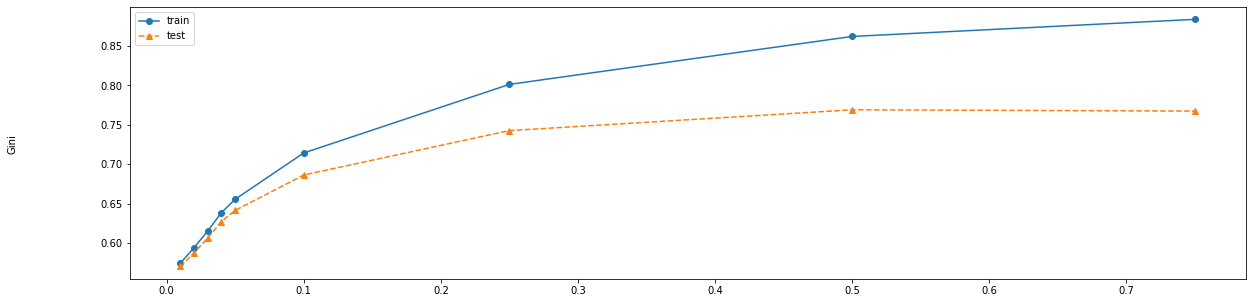

In [33]:
plot_search_results(data_hypertune_lr,'learning_rate')

### 2.2.2. Finetune the number of boosts

In [37]:
xgboost_type = "Train"
learning_rate = [0.08]
n_estimators = [75, 100, 120, 150, 250]
subsample = [1]
max_depth = [6]
seed = 1024
data_hypertune_n = xgboost_fine01(xgboost_type,n_estimators,'n')



***** Run:  0  |  Number of boosts : 75
[00:11:57] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.669651    0.65295
Execution time: 00:04:03


***** Run:  1  |  Number of boosts : 100
[00:16:00] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.695241   0.672901
Execution time: 00:05:23


***** Run:  2  |  Number of boosts : 120
[00:21:23] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.712756   0.685642
Execution time: 00:06:28


***** Run:  3  |  Number of boosts : 150
[00:27:52] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.736012   0.702101
Execution time: 00:07:52


***** Run:  4  |  Number of boosts : 250
[00:35:44] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.789142    0.73926
Execution time: 00:13:16


/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [38]:
data_hypertune_n

,num_boost_round,learning_rate,subsample,max_depth,gini_train,gini_test,auroc_train,auroc_test,train_test_change
0,75.0,0.08,1.0,6.0,0.669651,0.652950,0.834825,0.826475,-0.024939
1,100.0,0.08,1.0,6.0,0.695241,0.672901,0.847620,0.836451,-0.032132
2,120.0,0.08,1.0,6.0,0.712756,0.685642,0.856378,0.842821,-0.038041
3,150.0,0.08,1.0,6.0,0.736012,0.702101,0.868006,0.851051,-0.046073
4,250.0,0.08,1.0,6.0,0.789142,0.739260,0.894571,0.869630,-0.063210


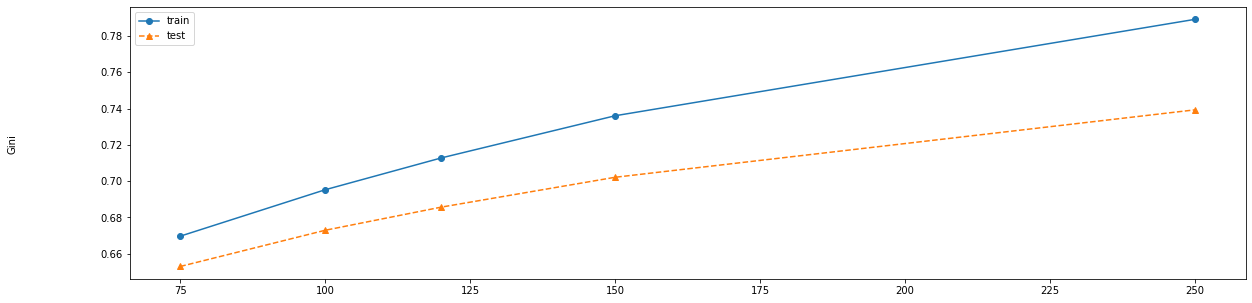

In [39]:
plot_search_results(data_hypertune_n,'num_boost_round')

### 2.2.3. Finetune the subsample

In [40]:
xgboost_type = "Train"
learning_rate = [0.08]
n_estimators = [120]
subsample = [0.2, 0.4, 0.6, 0.8, 1]
max_depth = [6]
seed = 1024
data_hypertune_ss = xgboost_fine01(xgboost_type,subsample,'ss')



***** Run:  0  |  Subsample size : 0.2
[01:17:41] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.699072   0.673233
Execution time: 00:05:15


***** Run:  1  |  Subsample size : 0.4
[01:22:57] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.708146   0.682113
Execution time: 00:06:54


***** Run:  2  |  Subsample size : 0.6
[01:29:51] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.710181   0.682494
Execution time: 00:07:36


***** Run:  3  |  Subsample size : 0.8
[01:37:27] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.712191   0.685598
Execution time: 00:06:52


***** Run:  4  |  Subsample size : 1
[01:44:20] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.712756   0.685642
Execution time: 00:06:13


/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [41]:
data_hypertune_ss

,num_boost_round,learning_rate,subsample,max_depth,gini_train,gini_test,auroc_train,auroc_test,train_test_change
0,120.0,0.08,0.2,6.0,0.699072,0.673233,0.849536,0.836616,-0.036963
1,120.0,0.08,0.4,6.0,0.708146,0.682113,0.854073,0.841056,-0.036762
2,120.0,0.08,0.6,6.0,0.710181,0.682494,0.855090,0.841247,-0.038985
3,120.0,0.08,0.8,6.0,0.712191,0.685598,0.856095,0.842799,-0.037339
4,120.0,0.08,1.0,6.0,0.712756,0.685642,0.856378,0.842821,-0.038041


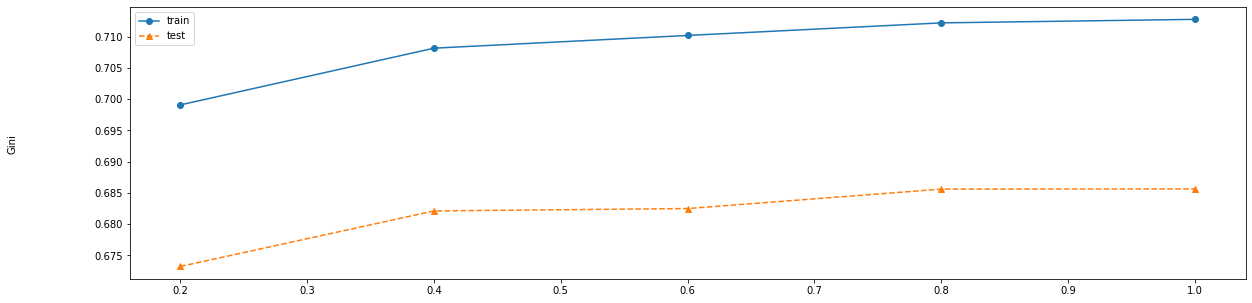

In [42]:
plot_search_results(data_hypertune_ss,'subsample')

### 2.2.4. Finetune the maximum depth

In [43]:
xgboost_type = "Train"
learning_rate = [0.08]
n_estimators = [120]
subsample = [0.8]
max_depth = [2, 4, 6, 8, 10]
seed = 1024
data_hypertune_md = xgboost_fine01(xgboost_type,max_depth,'md')



***** Run:  0  |  Maximum depth : 2
[01:52:22] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.596962    0.59281
Execution time: 00:03:01


***** Run:  1  |  Maximum depth : 4
[01:55:24] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.642292   0.633301
Execution time: 00:05:01


***** Run:  2  |  Maximum depth : 6
[02:00:25] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.712191   0.685598
Execution time: 00:07:04


***** Run:  3  |  Maximum depth : 8
[02:07:30] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.838605   0.769623
Execution time: 00:09:34


***** Run:  4  |  Maximum depth : 10
[02:17:04] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.959428   0.852305
Execution time: 00:12:44


/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [44]:
data_hypertune_md

,num_boost_round,learning_rate,subsample,max_depth,gini_train,gini_test,auroc_train,auroc_test,train_test_change
0,120.0,0.08,0.8,2.0,0.596962,0.592810,0.798481,0.796405,-0.006955
1,120.0,0.08,0.8,4.0,0.642292,0.633301,0.821146,0.816651,-0.013997
2,120.0,0.08,0.8,6.0,0.712191,0.685598,0.856095,0.842799,-0.037339
3,120.0,0.08,0.8,8.0,0.838605,0.769623,0.919303,0.884811,-0.082259
4,120.0,0.08,0.8,10.0,0.959428,0.852305,0.979714,0.926153,-0.111653


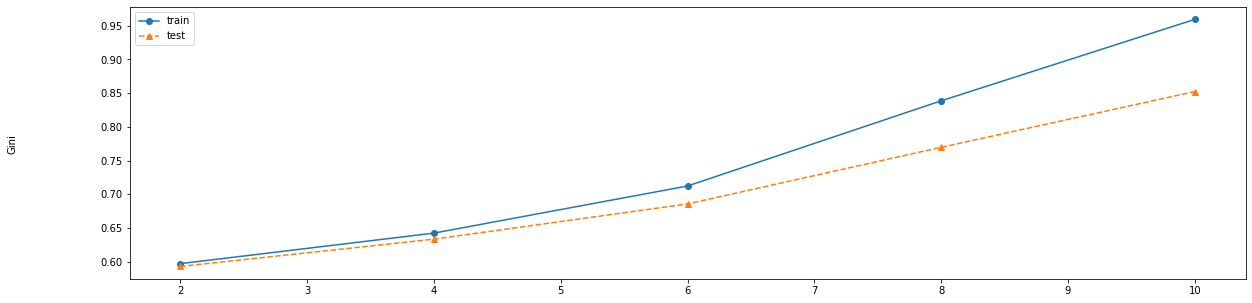

In [45]:
plot_search_results(data_hypertune_md,'max_depth')

## 2.3. Execute and save the best configuration

In [27]:
lr = 0.08
n = 120
ss = 0.08
md = 6
seed = 1024

params_train={
    'objective': 'binary:logistic',
    'num_round':n,
    'learning_rate':lr,
    'subsample':ss,    
    'max_depth':md,
    'seed':seed,
    'eval_metric':'auc'
}

watchlist = [(data_dmatrix_test, 'eval'), (data_dmatrix_train, 'train')]
best_model_train = xgb.train(
    params_train, 
    data_dmatrix_train, 
    n,
    evals=watchlist,
    verbose_eval=False
)

[13:32:25] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



In [28]:
y_train_pred = best_model_train.predict(data_dmatrix_train) 
roc_auc_train = roc_auc_score(y_train, y_train_pred)
gini_train = 2*roc_auc_train - 1

y_test_pred = best_model_train.predict(data_dmatrix_test) 
roc_auc_test = roc_auc_score(y_test, y_test_pred)
gini_test = 2*roc_auc_test - 1
train_test_change = (gini_test/gini_train)-1

print("Gini train:", gini_train)
print("Gini test:", gini_test)

Gini train: 0.674757095329086
Gini test: 0.6538710673832604


<AxesSubplot: >

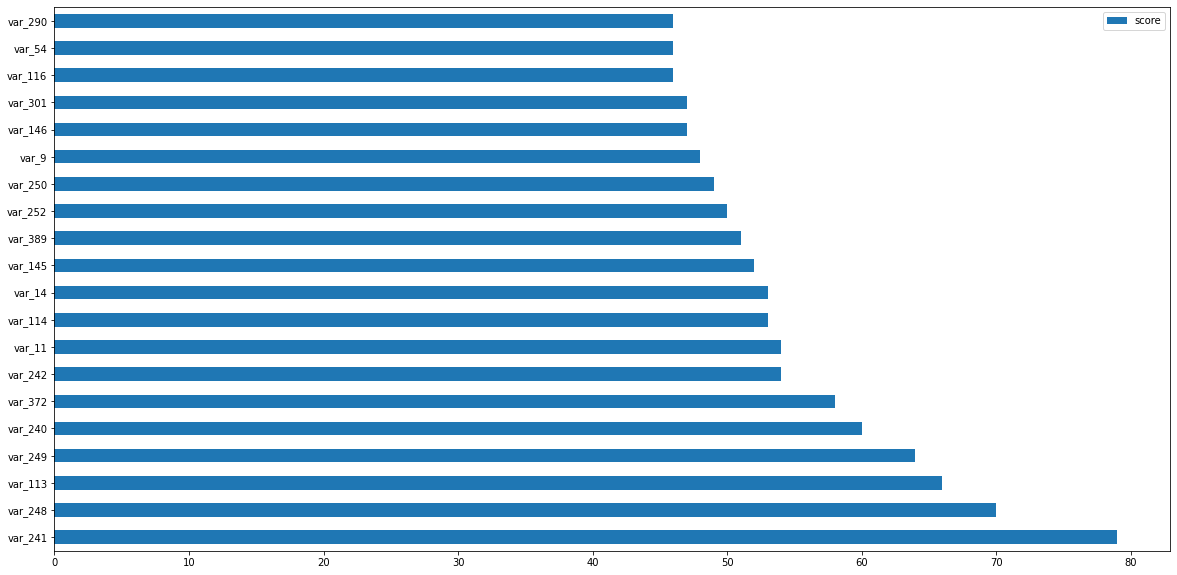

In [29]:
feature_important = best_model_train.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_features = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_features.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 20 features

In [30]:
num = data_features.shape[0]
num

333

In [31]:
num = data_features.shape[0]
results_data_model_optimized = pd.DataFrame(columns=['top_features_num','gini_train','gini_test','auc_train','auc_test','train_test_change'])
results_data_model_optimized.loc[0] = [num,gini_train,gini_test,roc_auc_train,roc_auc_test,train_test_change]
results_data_model_optimized

,top_features_num,gini_train,gini_test,auc_train,auc_test,train_test_change
0,333.0,0.674757,0.653871,0.837379,0.826936,-0.030953


## 2.4. Execute the xgboost using the most important features

In [32]:
def func_xgboost_selfeatures(num_selected_features):
    global results_data
    results_data = pd.DataFrame(columns=['top_features_num','gini_train','gini_test','auc_train','auc_test','train_test_change'])
    i = 0
    for num in num_selected_features:
        st = time.time()
        print("")
        print("**********************************************************************************************************")
        print("Number of top features:", num)
        data_selected_features = data_features[:num]

        selected_features = data_selected_features.index.to_list()
        X_train2 = X_train[selected_features]
        X_test2 = X_test[selected_features]
        data_dmatrix_train2 = xgb.DMatrix(data=X_train2,label=y_train)
        data_dmatrix_test2 = xgb.DMatrix(data=X_test2,label=y_test)

        lr = 0.1
        n = 250
        ss = 1
        md = 6
        seed = 1024

        params_train={
        'objective': 'binary:logistic',
        'num_round':n,
        'learning_rate':lr,
        'subsample':ss,    
        'max_depth':md,
        'seed':seed,
        'eval_metric':'auc'
        }

        watchlist = [(data_dmatrix_test2, 'eval'), (data_dmatrix_train2, 'train')]
        best_model_train2 = xgb.train(
            params_train, 
            data_dmatrix_train2, 
            n,
            evals=watchlist,
            verbose_eval=False
        )

        y_train_pred = best_model_train2.predict(data_dmatrix_train2) 
        roc_auc_train = roc_auc_score(y_train, y_train_pred)
        gini_train = 2*roc_auc_train - 1

        y_test_pred = best_model_train2.predict(data_dmatrix_test2) 
        roc_auc_test = roc_auc_score(y_test, y_test_pred)
        gini_test = 2*roc_auc_test - 1
        train_test_change = (gini_test/gini_train)-1

        print("Gini train:", gini_train)
        print("Gini test:", gini_test)

        ara_data = pd.DataFrame(
            columns=[
                'top_features_num',
                'gini_train',
                'gini_test',
                'auc_train',
                'auc_test',
                'train_test_change'
                ]
        )

        ara_data.loc[0] = [num,gini_train,gini_test,roc_auc_train,roc_auc_test,train_test_change]

        results_data = results_data.append(ara_data, ignore_index=True)

        del ara_data

        i = i + 1

        et = time.time()
        elapsed_time = et - st
        print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
        
    return results_data

In [52]:
num_selected_features_inicial = [10, 15, 20, 25, 30, 40, 50, 75, 100]
results_data = func_xgboost_selfeatures(num_selected_features_inicial)


**********************************************************************************************************
Number of top features: 10
[02:46:00] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.6334761128047737
Gini test: 0.5989570546692686
Execution time: 00:01:14

**********************************************************************************************************
Number of top features: 15


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


[02:47:15] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.6755339041450532
Gini test: 0.6412447364389171
Execution time: 00:01:25

**********************************************************************************************************
Number of top features: 20


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


[02:48:41] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.6935470178389864
Gini test: 0.6551609405875685
Execution time: 00:01:43

**********************************************************************************************************
Number of top features: 25


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


[02:50:24] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.7107725155600957
Gini test: 0.6684303035485335
Execution time: 00:01:57

**********************************************************************************************************
Number of top features: 30


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


[02:52:22] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.7192703949506023
Gini test: 0.6768425277154715
Execution time: 00:02:07

**********************************************************************************************************
Number of top features: 40


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


[02:54:29] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.7314635675197845
Gini test: 0.6891444953317993
Execution time: 00:02:33

**********************************************************************************************************
Number of top features: 50


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


[02:57:03] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.7447804192946446
Gini test: 0.7001030228120668
Execution time: 00:02:56

**********************************************************************************************************
Number of top features: 75


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


[03:00:00] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.7692721328183922
Gini test: 0.7207213307690354
Execution time: 00:03:55

**********************************************************************************************************
Number of top features: 100


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


[03:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

Gini train: 0.7794805181766473
Gini test: 0.7274057001040706
Execution time: 00:05:06


/tmp/ipykernel_2741/1343551098.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data, ignore_index=True)


In [53]:
results_data_all = results_data.append(results_data_model_optimized)
results_data_all

/tmp/ipykernel_2741/1829555331.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data_all = results_data.append(results_data_model_optimized)


,top_features_num,gini_train,gini_test,auc_train,auc_test,train_test_change
0,10.0,0.633476,0.598957,0.816738,0.799479,-0.054491
1,15.0,0.675534,0.641245,0.837767,0.820622,-0.050759
2,20.0,0.693547,0.655161,0.846774,0.827580,-0.055347
3,25.0,0.710773,0.668430,0.855386,0.834215,-0.059572
4,30.0,0.719270,0.676843,0.859635,0.838421,-0.058987
5,40.0,0.731464,0.689144,0.865732,0.844572,-0.057855
6,50.0,0.744780,0.700103,0.872390,0.850052,-0.059987
7,75.0,0.769272,0.720721,0.884636,0.860361,-0.063113
8,100.0,0.779481,0.727406,0.889740,0.863703,-0.066807
0,333.0,0.674757,0.653871,0.837379,0.826936,-0.030953


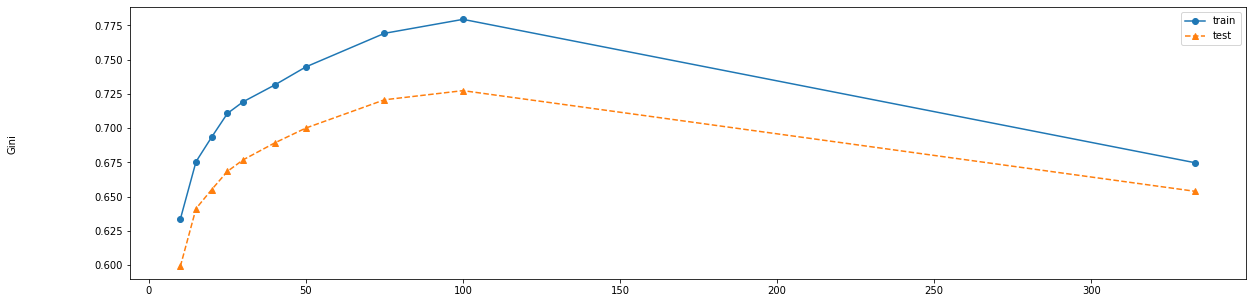

In [54]:
plot_search_results(results_data_all,'top_features_num')

## 2.5. Check whether the model's performance - where the model has been estimated with the selected features - can be increased 

In [33]:
data_selected_features = data_features[:25]
selected_features = data_selected_features.index.to_list() 
print(selected_features)
X_train = df_train_panda2[selected_features]
X_test = df_test_panda2[selected_features]

data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
data_dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)

df = pd.DataFrame({'variable':selected_features})
df.to_csv(ruta_reportes_mv + 'df_xgboost_topvars_varlist.csv', index=False)

['var_241', 'var_248', 'var_113', 'var_249', 'var_240', 'var_372', 'var_242', 'var_11', 'var_114', 'var_14', 'var_145', 'var_389', 'var_252', 'var_250', 'var_9', 'var_146', 'var_301', 'var_116', 'var_54', 'var_290', 'var_262', 'var_179', 'var_438', 'var_273', 'var_264']


### 2.5.1. Finetune the learning rate

In [56]:
xgboost_type = "Train"
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75]
n_estimators = [100]
subsample = [1]
max_depth = [6]
seed = 1024

data_hypertune_selected_lr = xgboost_fine01(xgboost_type,learning_rate,'lr')
print(data_hypertune_selected_lr)



***** Run:  0  |  Learning rate : 0.01
[03:11:02] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.561529   0.559378
Execution time: 00:00:47


***** Run:  1  |  Learning rate : 0.05
[03:11:50] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.612497   0.600271
Execution time: 00:00:46


***** Run:  2  |  Learning rate : 0.1
[03:12:37] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.646984   0.625594
Execution time: 00:00:48


***** Run:  3  |  Learning rate : 0.15
[03:13:25] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.668353   0.639335
Execution time: 00:00:46


***** Run:  4  |  Learning rate : 0.2
[03:14:11] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.689858   0.652158
Execution time: 00:00:46


***** Run:  5  |  Learning rate : 0.25
[03:14:57] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.707282   0.665248
Execution time: 00:00:47


***** Run:  6  |  Learning rate : 0.3
[03:15:44] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.720127   0.669572
Execution time: 00:00:46


***** Run:  7  |  Learning rate : 0.4
[03:16:31] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.745996   0.684683
Execution time: 00:00:47


***** Run:  8  |  Learning rate : 0.5
[03:17:18] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.757971   0.688677
Execution time: 00:00:46


***** Run:  9  |  Learning rate : 0.75
[03:18:05] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.782222   0.689886
Execution time: 00:00:47
   num_boost_round  learning_rate  subsample  max_depth  gini_train  \
0            100.0           0.01        1.0        6.0    0.561529   
1            100.0           0.05        1.0        6.0    0.612497   
2            100.0           0.10        1.0        6.0    0.646984   
3            100.0           0.15        1.0        6.0    0.668353   
4            100.0           0.20        1.0        6.0    0.689858   
5            100.0           0.25        1.0        6.0    0.707282   
6            100.0           0.30        1.0        6.0    0.720127   
7            100.0           0.40        1.0        6.0    0.745996   
8            100.0           0.50        1.0        6.0    0.757971   
9           

/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [57]:
data_hypertune_selected_lr

,num_boost_round,learning_rate,subsample,max_depth,gini_train,gini_test,auroc_train,auroc_test,train_test_change
0,100.0,0.01,1.0,6.0,0.561529,0.559378,0.780765,0.779689,-0.003831
1,100.0,0.05,1.0,6.0,0.612497,0.600271,0.806249,0.800135,-0.019962
2,100.0,0.10,1.0,6.0,0.646984,0.625594,0.823492,0.812797,-0.033062
3,100.0,0.15,1.0,6.0,0.668353,0.639335,0.834177,0.819667,-0.043418
4,100.0,0.20,1.0,6.0,0.689858,0.652158,0.844929,0.826079,-0.054650
5,100.0,0.25,1.0,6.0,0.707282,0.665248,0.853641,0.832624,-0.059430
6,100.0,0.30,1.0,6.0,0.720127,0.669572,0.860063,0.834786,-0.070203
7,100.0,0.40,1.0,6.0,0.745996,0.684683,0.872998,0.842342,-0.082189
8,100.0,0.50,1.0,6.0,0.757971,0.688677,0.878985,0.844338,-0.091421
9,100.0,0.75,1.0,6.0,0.782222,0.689886,0.891111,0.844943,-0.118043


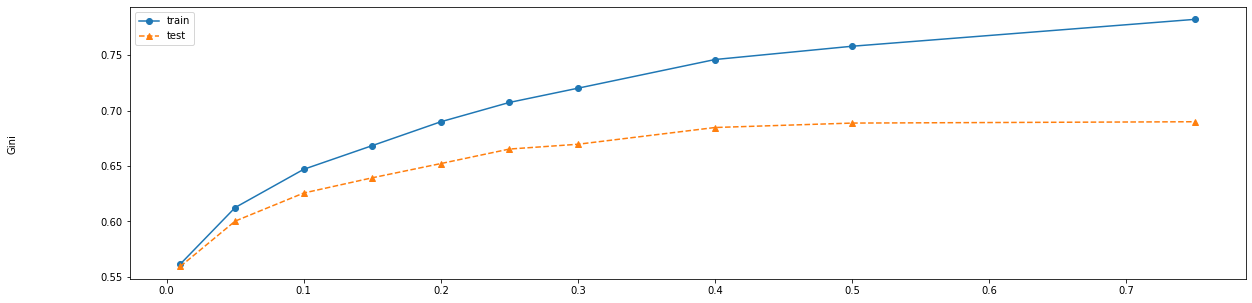

In [58]:
plot_search_results(data_hypertune_selected_lr,'learning_rate')

### 2.5.2. Finetune the number of boosts

In [59]:
xgboost_type = "Train"
learning_rate = [0.15]
n_estimators = [50, 75, 100, 120, 150, 180, 200]
subsample = [1]
max_depth = [6]
seed = 1024

data_hypertune_selected_n = xgboost_fine01(xgboost_type,n_estimators,'n')
print(data_hypertune_selected_n)



***** Run:  0  |  Number of boosts : 50
[03:28:54] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0     0.63148   0.613569
Execution time: 00:00:24


***** Run:  1  |  Number of boosts : 75
[03:29:18] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.650873   0.627445
Execution time: 00:00:34


***** Run:  2  |  Number of boosts : 100
[03:29:53] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.668353   0.639335
Execution time: 00:00:47


***** Run:  3  |  Number of boosts : 120
[03:30:40] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.681517   0.649289
Execution time: 00:00:55


***** Run:  4  |  Number of boosts : 150
[03:31:36] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.699755   0.660779
Execution time: 00:01:09


***** Run:  5  |  Number of boosts : 180
[03:32:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.716531   0.671102
Execution time: 00:01:24


***** Run:  6  |  Number of boosts : 200
[03:34:10] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.726179    0.67699
Execution time: 00:01:34
   num_boost_round  learning_rate  subsample  max_depth  gini_train  \
0             50.0           0.15        1.0        6.0    0.631480   
1             75.0           0.15        1.0        6.0    0.650873   
2            100.0           0.15        1.0        6.0    0.668353   
3            120.0           0.15        1.0        6.0    0.681517   
4            150.0           0.15        1.0        6.0    0.699755   
5            180.0           0.15        1.0        6.0    0.716531   
6            200.0           0.15        1.0        6.0    0.726179   

   gini_test  auroc_train  auroc_test  train_test_change  
0   0.613569     0.815740    0.806785          -0.028363  
1   0.627445     0.825436    0.81

/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [60]:
xgboost_type = "Train"
learning_rate = [0.15]
n_estimators = [500]
subsample = [1]
max_depth = [6]
seed = 1024
data_hypertune_selected_n2 = xgboost_fine01(xgboost_type,n_estimators,'n')



***** Run:  0  |  Number of boosts : 500
[03:35:45] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.828682   0.738325
Execution time: 00:04:06


/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [61]:
data_hypertune_selected_n3 = data_hypertune_selected_n.append(data_hypertune_selected_n2)

/tmp/ipykernel_2741/1252718386.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_hypertune_selected_n3 = data_hypertune_selected_n.append(data_hypertune_selected_n2)


In [62]:
data_hypertune_selected_n3

,num_boost_round,learning_rate,subsample,max_depth,gini_train,gini_test,auroc_train,auroc_test,train_test_change
0,50.0,0.15,1.0,6.0,0.631480,0.613569,0.815740,0.806785,-0.028363
1,75.0,0.15,1.0,6.0,0.650873,0.627445,0.825436,0.813723,-0.035994
2,100.0,0.15,1.0,6.0,0.668353,0.639335,0.834177,0.819667,-0.043418
3,120.0,0.15,1.0,6.0,0.681517,0.649289,0.840759,0.824644,-0.047289
4,150.0,0.15,1.0,6.0,0.699755,0.660779,0.849878,0.830389,-0.055700
5,180.0,0.15,1.0,6.0,0.716531,0.671102,0.858265,0.835551,-0.063401
6,200.0,0.15,1.0,6.0,0.726179,0.676990,0.863089,0.838495,-0.067737
0,500.0,0.15,1.0,6.0,0.828682,0.738325,0.914341,0.869162,-0.109038


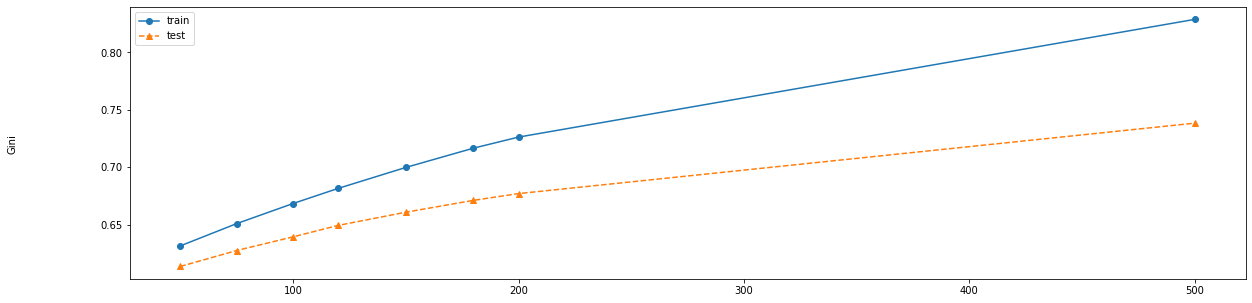

In [63]:
plot_search_results(data_hypertune_selected_n3,'num_boost_round')

### 2.5.3. Finetune the subsample

In [64]:
xgboost_type = "Train"
learning_rate = [0.15]
n_estimators = [120]
subsample = [0.2, 0.4, 0.6, 0.8, 1]
max_depth = [6]
seed = 1024
data_hypertune_selected_ss = xgboost_fine01(xgboost_type,subsample,'ss')



***** Run:  0  |  Subsample size : 0.2
[03:43:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.660161   0.625664
Execution time: 00:00:58


***** Run:  1  |  Subsample size : 0.4
[03:44:44] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.676914   0.643712
Execution time: 00:01:07


***** Run:  2  |  Subsample size : 0.6
[03:45:52] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.683577   0.649879
Execution time: 00:01:09


***** Run:  3  |  Subsample size : 0.8
[03:47:01] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.686447    0.64921
Execution time: 00:01:06


***** Run:  4  |  Subsample size : 1
[03:48:07] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.681517   0.649289
Execution time: 00:01:00


/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [65]:
data_hypertune_selected_ss

,num_boost_round,learning_rate,subsample,max_depth,gini_train,gini_test,auroc_train,auroc_test,train_test_change
0,120.0,0.15,0.2,6.0,0.660161,0.625664,0.830081,0.812832,-0.052256
1,120.0,0.15,0.4,6.0,0.676914,0.643712,0.838457,0.821856,-0.049049
2,120.0,0.15,0.6,6.0,0.683577,0.649879,0.841789,0.824940,-0.049296
3,120.0,0.15,0.8,6.0,0.686447,0.649210,0.843224,0.824605,-0.054246
4,120.0,0.15,1.0,6.0,0.681517,0.649289,0.840759,0.824644,-0.047289


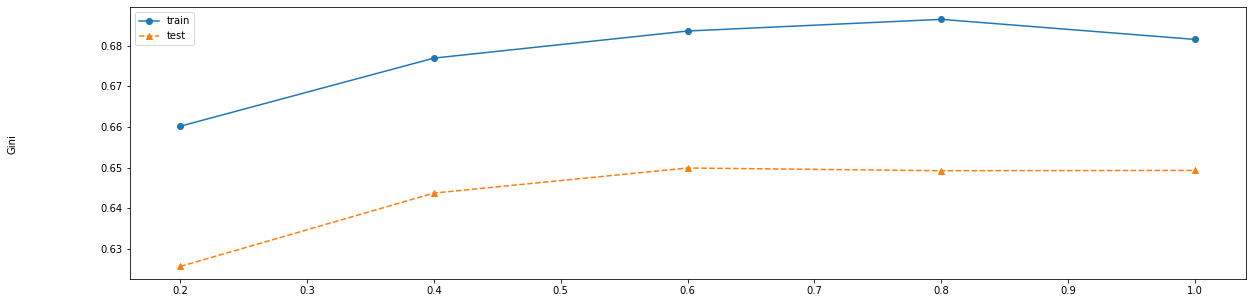

In [66]:
plot_search_results(data_hypertune_selected_ss,'subsample')

### 2.5.4. Finetune the maximum depth

In [67]:
xgboost_type = "Train"
learning_rate = [0.15]
n_estimators = [120]
subsample = [0.8]
max_depth = [2, 4, 6, 8, 10]
seed = 1024
data_hypertune_selected_md = xgboost_fine01(xgboost_type,max_depth,'md')



***** Run:  0  |  Maximum depth : 2
[03:51:52] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.586766   0.580275
Execution time: 00:00:29


***** Run:  1  |  Maximum depth : 4
[03:52:22] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.619382   0.607405
Execution time: 00:00:44


***** Run:  2  |  Maximum depth : 6
[03:53:06] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.686447    0.64921
Execution time: 00:01:06


***** Run:  3  |  Maximum depth : 8
[03:54:12] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


   gini_train  gini_test
0    0.810184   0.729722
Execution time: 00:01:34


***** Run:  4  |  Maximum depth : 10
[03:55:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

   gini_train  gini_test
0    0.942988   0.812005
Execution time: 00:02:04


/tmp/ipykernel_2741/3687071205.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_data = results_data.append(ara_data,ignore_index=True)


In [68]:
data_hypertune_selected_md3 = data_hypertune_selected_md
data_hypertune_selected_md3

,num_boost_round,learning_rate,subsample,max_depth,gini_train,gini_test,auroc_train,auroc_test,train_test_change
0,120.0,0.15,0.8,2.0,0.586766,0.580275,0.793383,0.790138,-0.011061
1,120.0,0.15,0.8,4.0,0.619382,0.607405,0.809691,0.803702,-0.019337
2,120.0,0.15,0.8,6.0,0.686447,0.649210,0.843224,0.824605,-0.054246
3,120.0,0.15,0.8,8.0,0.810184,0.729722,0.905092,0.864861,-0.099313
4,120.0,0.15,0.8,10.0,0.942988,0.812005,0.971494,0.906002,-0.138902


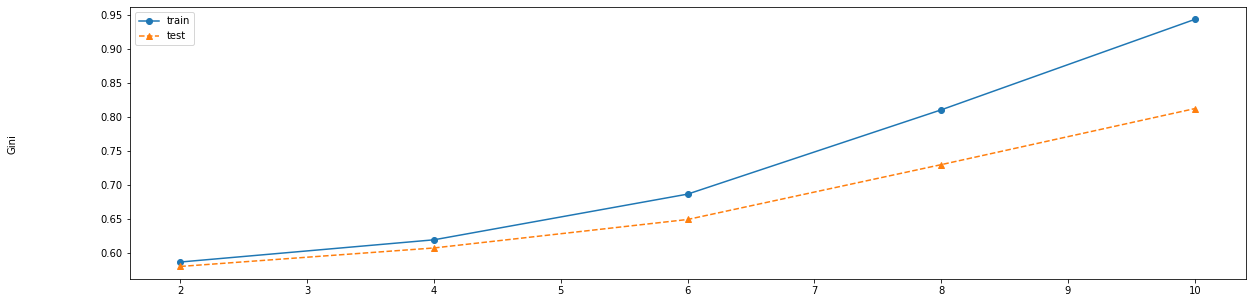

In [69]:
plot_search_results(data_hypertune_selected_md3,'max_depth')

## 2.6. Execute and save the best configuration 2

In [34]:
lr = 0.15
n = 120
ss = 0.8
md = 6
seed = 1024

params_train={
    'objective': 'binary:logistic',
    'num_round':n,
    'learning_rate':lr,
    'subsample':ss,    
    'max_depth':md,
    'seed':seed,
    'eval_metric':'auc'
}

watchlist = [(data_dmatrix_test, 'eval'), (data_dmatrix_train, 'train')]
best_model_train = xgb.train(
    params_train, 
    data_dmatrix_train, 
    n,
    evals=watchlist,
    verbose_eval=False
)

[13:36:30] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.



In [35]:
y_train_pred = best_model_train.predict(data_dmatrix_train) 
roc_auc_train = roc_auc_score(y_train, y_train_pred)
gini_train = 2*roc_auc_train - 1

y_test_pred = best_model_train.predict(data_dmatrix_test) 
roc_auc_test = roc_auc_score(y_test, y_test_pred)
gini_test = 2*roc_auc_test - 1
train_test_change = (gini_test/gini_train)-1

print("Gini train:", gini_train)
print("Gini test:", gini_test)

Gini train: 0.6864470155633813
Gini test: 0.6492096680516564


<AxesSubplot: >

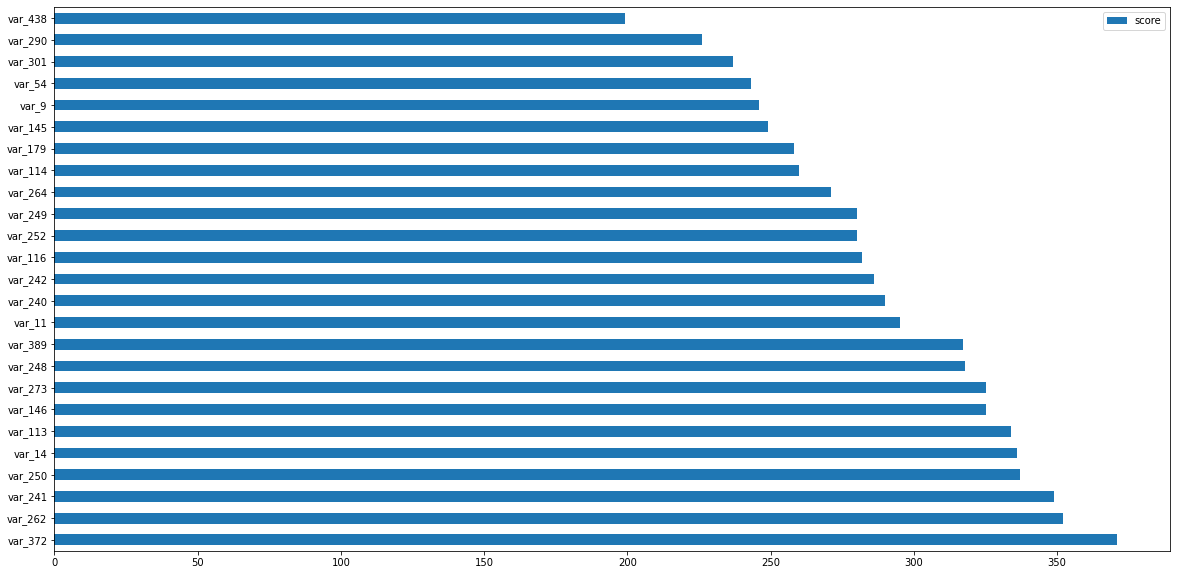

In [36]:
feature_important = best_model_train.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_features = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_features.nlargest(30, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 20 features

In [37]:

best_model_train.save_model(WS_PATH_Reportes + "best_model.json")
best_model_train.save_model(WS_PATH_Reportes + "best_model.txt")

In [38]:
features= pd.DataFrame(data_dmatrix_train.feature_names)
features.to_csv(WS_PATH_Reportes + "best_model_features_2.csv", index=False)

In [41]:
features

,0
0,var_241
1,var_248
2,var_113
3,var_249
4,var_240
5,var_372
6,var_242
7,var_11
8,var_114
9,var_14


In [40]:
data_features

,score
var_372,371.0
var_262,352.0
var_241,349.0
var_250,337.0
var_14,336.0
var_113,334.0
var_146,325.0
var_273,325.0
var_248,318.0
var_389,317.0
